# Analyis NLP
That’s what the data said: An NLP Analysis of Character Relationships and Speaking Styles in the US TV-Show “The Office”
That’s what the data said: An NLP Analysis of the Script of the US TV-Show “The Office”

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer

from preprocessing_nlp import preprocess, extract_features

PATH = "../data/"
FILE = "the-office-lines_scripts.csv"

In [2]:
df_raw = pd.read_csv(PATH+FILE, sep=",", index_col="id")
df_raw.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [3]:
param_dict = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": False, 
    "exp_contractions": False,
    "conversion": None
}

df = preprocess(df_raw, **param_dict)
df.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,101,NaN
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,101,NaN
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,101,NaN
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,101,NaN
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,101,NaN


In [4]:
char_app = df.sort_values(['season','episode','scene']).drop_duplicates(['season','episode','scene','speaker'],keep='first')
char_app_count = char_app.groupby(['speaker', 'season']).size().reset_index(name='counts')

char_app_count['season'] = char_app_count['season'].astype(str)

top_char = char_app.groupby(['speaker']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)['speaker'].iloc[:20]

#filter for top 20 characters
char_app_count_sorted = char_app_count[char_app_count['speaker'].isin(top_char)].sort_values(by=['season'])

fig = px.bar(char_app_count_sorted, x='speaker', y='counts', color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Scene appearances per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_char)


In [5]:
top20_characters = df["speaker"].value_counts().head(20).index.tolist()
lines_per_character = df[["speaker", "season", "line_text"]][df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).count().reset_index(level=[0,1])
lines_per_character['season'] = lines_per_character['season'].astype(str)
fig = px.bar(lines_per_character.sort_values("season"), x="speaker", y="line_text", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Lines per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of lines')

In [6]:
words_df = df.copy()
words_df['word_count'] = words_df['line_text'].apply(lambda x: len(x.split()))
top20_characters = words_df[["speaker", "word_count"]].groupby("speaker").sum().sort_values("word_count", ascending=False).index[:20]
words_per_character = words_df[["speaker", "season", "word_count"]][words_df["speaker"].isin(top20_characters)].groupby(["speaker", "season"]).sum().reset_index(level=[0,1])
words_per_character['season'] = words_per_character['season'].astype(str)

fig = px.bar(words_per_character.sort_values("season"), x="speaker", y="word_count", color='season', color_discrete_sequence=px.colors.qualitative.Prism, title='Words per character')
fig.update_xaxes(categoryorder='array', categoryarray= top20_characters)
fig.update_yaxes(title='number of words')

In [7]:
speaker_list = ["Michael", "Dwight", "Jim", "Pam", "Andy"]

lines_per_speaker_episode = df.loc[df["speaker"].isin(speaker_list)].groupby(["speaker", "season_episode"]).count()["line_text"].unstack(fill_value=0).stack().reset_index(level=['speaker', 'season_episode']).sort_values("season_episode")
lines_per_speaker_episode.sort_values(["season_episode"], inplace=True)
lines_per_speaker_episode.rename(columns={0: "number of lines"}, inplace=True)

fig = px.line(lines_per_speaker_episode, x="season_episode", y="number of lines", color="speaker", title="Lines per speaker and episode")

fig.add_annotation(
    x=17
    , y=170
    , text=f'Andy is introduced'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=87.5
    , y=170
    , text=f'Birth of Jim and Pam\'s daughter'
    , showarrow=False
    , align="left")

fig.add_annotation(
    x=126.5
    , y=170
    , text=f'Michael leaves'
    , showarrow=False
    , align="left")

fig.update_layout(shapes=
                  [dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=28, x1=28,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=106, x1=106,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                    dict(type= 'line',
                        yref= 'paper', y0= 0, y1= 1,
                        xref= 'x', x0=135, x1=135,
                        line=dict(color="Black",
                                  width=1,
                                  dash="dot")
                        ),
                  ]                
                  )

fig.add_vrect(x0="170", x1="176", 
              annotation_text="Andy is on a boat trip", annotation_position="top right",  
              annotation_font_size=11,
              annotation_font_color="Blue",
              fillcolor="blue", opacity=0.25, line_width=0)

In [11]:
param_dict_tokens = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df_tokens = preprocess(df_raw, **param_dict_tokens)
df_tokens.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[all, right, jim, your, quarterlies, look, very, good, how, are, things, at, the, library]",Michael,101,NaN
2,1,1,1,"[oh, i, told, you, i, could, not, close, it, so]",Jim,101,NaN
3,1,1,1,"[so, you, have, come, to, the, master, for, guidance, is, this, what, you, are, saying, grasshopper]",Michael,101,NaN
4,1,1,1,"[actually, you, called, me, in, here, but, yeah]",Jim,101,NaN
5,1,1,1,"[all, right, well, let, me, show, you, how, it, is, done]",Michael,101,NaN


In [12]:
all_words =  [item for sublist in df_tokens["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

fig = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words')
fig.update_layout(yaxis_title='Word', xaxis_title='Frequency')

fig.show()


In [14]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": True,
    "lwr": True, 
    "exp_contractions": True,
    "conversion": "tokenize",
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df_tokens_nostopwords = preprocess(df_raw, **param_dict_tokens_nostopwords)
df_tokens_nostopwords.head()

,season,episode,scene,line_text,speaker,season_episode,directionals
id,,,,,,,
1,1,1,1,"[right, jim, quarterlies, look, good, things, library]",Michael,101,NaN
2,1,1,1,"[oh, told, could, close]",Jim,101,NaN
3,1,1,1,"[come, master, guidance, saying, grasshopper]",Michael,101,NaN
4,1,1,1,"[actually, called, yeah]",Jim,101,NaN
5,1,1,1,"[right, well, let, show, done]",Michael,101,NaN


In [15]:
all_words =  [item for sublist in df_tokens_nostopwords["line_text"].tolist() for item in sublist]
all_words_freq = nltk.FreqDist(all_words)
df_all_words_freq = pd.Series(dict(all_words_freq)).sort_values(ascending=False)

fig2 = px.bar(y=df_all_words_freq[:16].index, x=df_all_words_freq[:16].values, orientation='h', title='Most common words (after stopword removal)')
fig2.show()

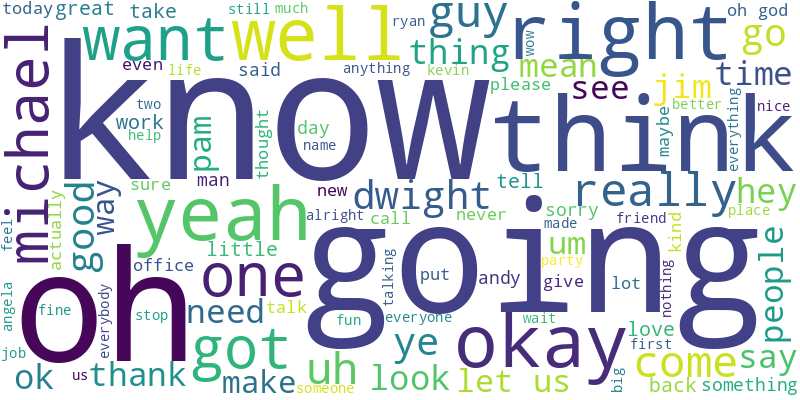

In [ ]:
# create a wordcloud from all_words
from matplotlib import pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, contour_width=3, contour_color='steelblue').generate(" ".join(all_words))
wordcloud.to_image()


In [88]:
param_dict_tokens_nostopwords = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": False, 
    "exp_contractions": False,
    "conversion": "pos_tag"
}

df_tokens_tagged = preprocess(df_raw, **param_dict_tokens_nostopwords)

### Finding the most important Words using the Brill Tagger

In [ ]:
from nltk.tag import BrillTaggerTrainer, UnigramTagger, brill, brill_trainer

tagged_sentences = df_tokens_tagged["line_text"].values.tolist()

In [80]:
tagged_sentences_filtered = []

for element in tagged_sentences:
    if element != []:
        tagged_sentences_filtered.append(element)

In [81]:

train_data = tagged_sentences_filtered[:50000]
test_data = tagged_sentences_filtered[50000:]

In [83]:
templates = [
    brill.Template(brill.Pos([-1])),
    brill.Template(brill.Pos([1])),
    brill.Template(brill.Pos([-2])),
    brill.Template(brill.Pos([2])),
    brill.Template(brill.Pos([-2, -1])),
    brill.Template(brill.Pos([1, 2])),
    brill.Template(brill.Pos([-3, -2, -1])),
    brill.Template(brill.Pos([1, 2, 3])),
    brill.Template(brill.Word([-1])),
    brill.Template(brill.Word([1])),
    brill.Template(brill.Word([-2])),
    brill.Template(brill.Word([2])),
    brill.Template(brill.Word([-2, -1])),
    brill.Template(brill.Word([1, 2])),
    brill.Template(brill.Word([-3, -2, -1])),
    brill.Template(brill.Word([1, 2, 3])),
    brill.Template(brill.Word([-1]), brill.Pos([1])),
    brill.Template(brill.Word([1]), brill.Pos([-1])),
]

unigram_tagger = UnigramTagger(train_data)
trainer = BrillTaggerTrainer(unigram_tagger, templates, trace=3)
brill_tagger = trainer.train(train_data, max_rules=10)

TBL train (fast) (seqs: 50000; tokens: 690199; tpls: 18; min score: 2; min acc: None)
Finding initial useful rules...
    Found 248865 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
22342253  19   6  | VBP->VB if Word:n't@[-2,-1]
14031564 161  11  | VBP->VB if Pos:MD@[-3,-2,-1]
13191359  40  14  | VBP->VB if Pos:TO@[-2,-1]
 93731322195 124  | VB->VBP if Pos:PRP@[-1]
 8811003 122   4  | VBP->VB if Pos:MD@[-3,-2,-1]
 688 848 160   8  | VBP->VB if Word:do@[-3,-2,-1]
 663 781 118 479  | IN->DT if Pos:VBZ@[1]
 570 693 123  52  | VBZ->POS if Pos:VB@[-1]
 445 799 354 184  | VB->NN if Pos:DT@[-2,-1]
 415 736 321  80  | NN->VB if Pos:MD@[-2,-1

In [84]:
accuracy = brill_tagger.evaluate(test_data)
print("Brill Tagger accuracy:", accuracy)

Brill Tagger accuracy: 0.8929287226534933


C:\Users\schla\AppData\Local\Temp\ipykernel_9480\281381312.py:1: DeprecationWarning:


  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.



In [99]:
param_dict_no_direc = {
    "concat_scenes": False,
    "extract_direc": True, 
    "remove_punct": True, 
    "rmv_stopwords": False,
    "lwr": False, 
    "exp_contractions": False,
    "conversion": "tokenize", 
    "tokenizer": ("TreeBankWord", True, PATH+"character_names.csv", PATH+"compound_words_the-office_by_chatgpt.txt")
}

df_no_direc = preprocess(df_raw, **param_dict_no_direc)

In [100]:
# apply the tagger to the whole dataset
result = df_no_direc["line_text"].apply(lambda x: brill_tagger.tag(x))

In [128]:
# filter words by POS tag
all_words_tagged =  [item for sublist in df_tokens_tagged["line_text"].tolist() for item in sublist]
all_words_tagged_filtered_jj = [item[0] for item in all_words_tagged if item[1] in ["JJ", "JJR", "JJS"]]
all_words_tagged_filtered_nn = [item[0] for item in all_words_tagged if item[1] in ["NN", "NNS", "NNP", "NNPS"]]

all_tagged_freq = nltk.FreqDist(all_words_tagged_filtered_jj)
df_all_tagged_freq = pd.Series(dict(all_tagged_freq)).sort_values(ascending=False)

fig2 = px.bar(y=df_all_tagged_freq[:30].index, x=df_all_tagged_freq[:30].values, orientation='h', title='Most common Adjectives (after tagging with brill tagger)', height=700)
fig2.update_traces(width=0.5)
fig2.show()

all_tagged_freq = nltk.FreqDist(all_words_tagged_filtered_nn)
df_all_tagged_freq = pd.Series(dict(all_tagged_freq)).sort_values(ascending=False)

fig3 = px.bar(y=df_all_tagged_freq[:30].index, x=df_all_tagged_freq[:30].values, orientation='h', title='Most common Nouns (after tagging with brill tagger)', height=700)
fig3.update_traces(width=0.5)
fig3.show()


### TF-IDF to determine important words in the dataset

In [139]:
param_dict_concat_scenes = {
    "concat_scenes": True,
    "extract_direc": True, 
    "remove_punct": False, 
    "rmv_stopwords": False,
    "lwr": True, 
    "exp_contractions": True,
}

df_concat_scenes = preprocess(df_raw, **param_dict_concat_scenes)

In [137]:
all_words_tagged_filtered = [item[0] for item in all_words_tagged]
features_tfidf_agg = extract_features(df_concat_scenes, "tfidf").mean(axis=0).sort_values(ascending=False)

# filter features_tfidf_agg by all_words_tagged_filtered
features_tfidf_agg = features_tfidf_agg[features_tfidf_agg.index.isin(all_words_tagged_filtered)]

In [140]:
features_tfidf_agg[0:10]

you     0.072911
is      0.056919
to      0.054235
the     0.052029
it      0.047500
that    0.040082
pam     0.039464
not     0.038828
and     0.037477
do      0.032911
dtype: float64

### Lexical Dispersion Plot

c:\Users\schla\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


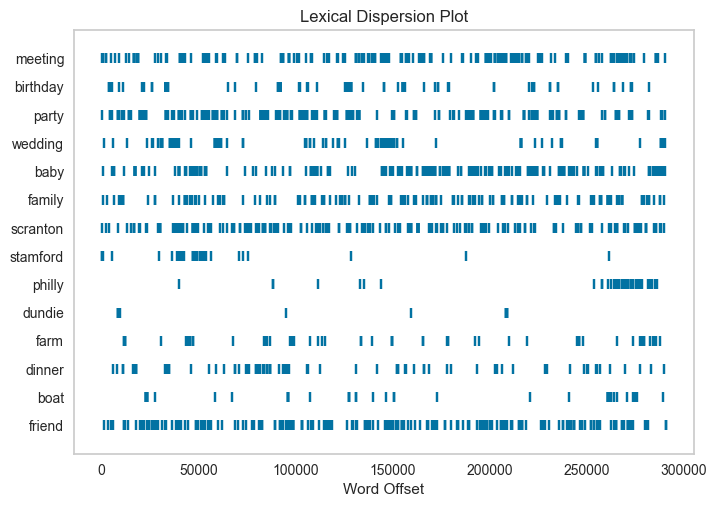

<AxesSubplot: title={'center': 'Lexical Dispersion Plot'}, xlabel='Word Offset'>

In [ ]:
from yellowbrick.text import DispersionPlot

target_words = ['meeting', 'birthday', 'party', 'wedding', 'baby', 'family', 'scranton', 'stamford', 'philly', 'dundie', 'farm', 'dinner', 'boat', 'friend']
visualizer = DispersionPlot(target_words)
visualizer.fit([all_words])
visualizer.show()

In [114]:
nltk.Text(all_words).concordance('lot', lines=10)

Displaying 10 of 529 matches:
people um sorry orientation race plus lot races intolerant gays soparadox well 
 really downloaded computer hope mind lot extra space way think likes stuff gre
 trying see mmm hmm listen going talk lot right may chatting giggling got prete
mber saying uh heard well people hear lot things man um starters course heard t
 new guy right untested willing prove lot passion lot heart getting paid skip l
ht untested willing prove lot passion lot heart getting paid skip lunch yes ok 
 technobabble okay company right sell lot branch made million dollars last year
ms would perfect hmmm talking michael lot assistant_regional_manager assistant_
pberry one really uh kind festive got lot personality yeah uh hey going good ta
ood night good night got oh yeah sold lot lighter good squeeze inside alright g


In [ ]:
#find n-grams
finder_2 = nltk.collocations.BigramCollocationFinder.from_words(all_words)
finder_3 = nltk.collocations.TrigramCollocationFinder.from_words(all_words)
finder_4 = nltk.collocations.QuadgramCollocationFinder.from_words(all_words)

finder_3.ngram_fd.most_common(20)

[(('let', 'us', 'go'), 203),
 (('let', 'us', 'get'), 107),
 (('hey', 'hey', 'hey'), 78),
 (('whoa', 'whoa', 'whoa'), 63),
 (('oh', 'god', 'oh'), 59),
 (('na', 'na', 'na'), 55),
 (('let', 'us', 'see'), 52),
 (('go', 'go', 'go'), 49),
 (('one', 'two', 'three'), 45),
 (('stop', 'stop', 'stop'), 44),
 (('god', 'oh', 'god'), 41),
 (('come', 'let', 'us'), 39),
 (('blah', 'blah', 'blah'), 37),
 (('ha', 'ha', 'ha'), 35),
 (('okay', 'let', 'us'), 34),
 (('yes', 'yes', 'yes'), 33),
 (('wait', 'wait', 'wait'), 32),
 (('get', 'back', 'work'), 31),
 (('yeah', 'yeah', 'yeah'), 28),
 (('oh', 'oh', 'oh'), 28)]

In [ ]:
# TODO: Document clustering/ Topic Modeling
# TODO: Sentiment Analysis (show how it evolves over time)
# TODO: also include network analysis

## Sentiment Analysis

In [ ]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("All right Jim. Your quarterlies look very good. How are things at the library?")

{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4927}

In [ ]:
# calculate sentiment scores for each line
df_sentiment = df_raw.copy()
df_sentiment["sentiment"] = df_raw["line_text"].apply(lambda x: sia.polarity_scores(x))

In [ ]:
# visualize sentiment scores over time

# set id as column 
df_sentiment['id'] = df_sentiment.index

# set new row as numerical
df_sentiment['neg'] = df_sentiment['sentiment'].apply(lambda x: x['neg'])
df_sentiment['neu'] = df_sentiment['sentiment'].apply(lambda x: x['neu'])
df_sentiment['pos'] = df_sentiment['sentiment'].apply(lambda x: x['pos'])


In [ ]:
df_rolling = df_sentiment.rolling(5).mean()

In [ ]:
# display sentiment over time for a given season and episode
px.line(df_rolling[(df_rolling["season"] == 5) & (df_rolling['episode'] == 16)], x="id", y=["neg", "neu", "pos"], title="Sentiment over time", color_discrete_sequence=px.colors.qualitative.Pastel)

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = "All right Jim. Your quarterlies look very good. How are things at the library?"
doc = nlp(text)
print(doc._.polarity)
print(doc._.subjectivity)
print(doc._.blob.sentiment_assessments.assessments)
print(doc._.blob.ngrams())

0.5978571428571429
0.6578571428571429
[(['right'], 0.2857142857142857, 0.5357142857142857, None), (['very', 'good'], 0.9099999999999999, 0.7800000000000001, None)]
[WordList(['All', 'right', 'Jim']), WordList(['right', 'Jim', 'Your']), WordList(['Jim', 'Your', 'quarterlies']), WordList(['Your', 'quarterlies', 'look']), WordList(['quarterlies', 'look', 'very']), WordList(['look', 'very', 'good']), WordList(['very', 'good', 'How']), WordList(['good', 'How', 'are']), WordList(['How', 'are', 'things']), WordList(['are', 'things', 'at']), WordList(['things', 'at', 'the']), WordList(['at', 'the', 'library'])]


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

text = "You are the best person ever!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = torch.softmax(output.logits, axis=1)
scores

tensor([[0.0020, 0.0062, 0.9918]], grad_fn=<SoftmaxBackward0>)

In [ ]:
# IDEA:
# TODO: only look at multiple selected characters at a time -> analysis of the relations (e.g. Dwight and Jim, Jim and Pam, Dwight and Angela, Kelly and Ryan, Michael and Toby)

## Network Analysis

In [ ]:
# create a list of the most important characters in the tv show the office
important_characters = ["Michael", "Dwight", "Jim", "Pam", "Ryan", "Andy", "Kevin", "Angela", "Oscar", "Phyllis", "Stanley", "Meredith", "Toby", "Kelly", "Creed",]

In [ ]:
speaker = df.groupby(['season', 'episode', 'scene'])['speaker'].apply(set).reset_index(name='speakers')

character_edges = {}
for c in speaker['speakers']:
    c = list(c)
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            character_tuple = (c[i], c[j])
            character_tuple_inv = (c[j], c[i])
            if character_tuple in character_edges:
                character_edges[character_tuple] += 1
            elif character_tuple_inv in character_edges:
                character_edges[character_tuple_inv] += 1
            else:
                character_edges[character_tuple] = 1

# only keep edges between important characters
character_edges = {k: v for k, v in character_edges.items() if k[0] in important_characters and k[1] in important_characters}

In [ ]:
import networkx as nx
import plotly.graph_objects as go

graph = nx.Graph()
for character_tuple, count in character_edges.items():
    graph.add_edge(character_tuple[0], character_tuple[1], weight=count)


node_weights = [sum([d['weight'] for (u, v, d) in graph.edges(data=True) if u == node]) for node in graph.nodes()]
total_weights = sum(node_weights)
node_weights_normalized = (np.array(node_weights)/total_weights)*500
pos = nx.spring_layout(graph, k=100, iterations=500)

import igviz as ig

ig.plot(graph,
size_method=list(node_weights_normalized)
)

C:\Users\schla\AppData\Local\Temp\ipykernel_51308\1025489642.py:16: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines',
              'text': [],
              'type': 'scatter',
              'uid': '8d8da493-6cd0-44d6-9f3a-290903dfd708',
              'x': [0.4051438868045807, 0.43939143419265747, None, ...,
                    0.7590225338935852, 0.9002222418785095, None],
              'y': [0.5358742475509644, 0.1694510132074356, None, ...,
                    0.6714473962783813, 0.21696414053440094, None]},
             {'hoverinfo': 'text',
              'hovertext': [Node: Jim<br>Degree: 14, Node: Michael<br>Degree: 14,
                            Node: Pam<br>Degree: 14, Node: Dwight<br>Degree: 14,
                            Node: Phyllis<br>Degree: 14, Node: Stanley<br>Degree:
                            14, Node: Kevin<br>Degree: 14, Node: Angela<br>Degree:
                            14, Node: Ryan<br>Degree: 14, Node: Oscar<br>Degree:
                       

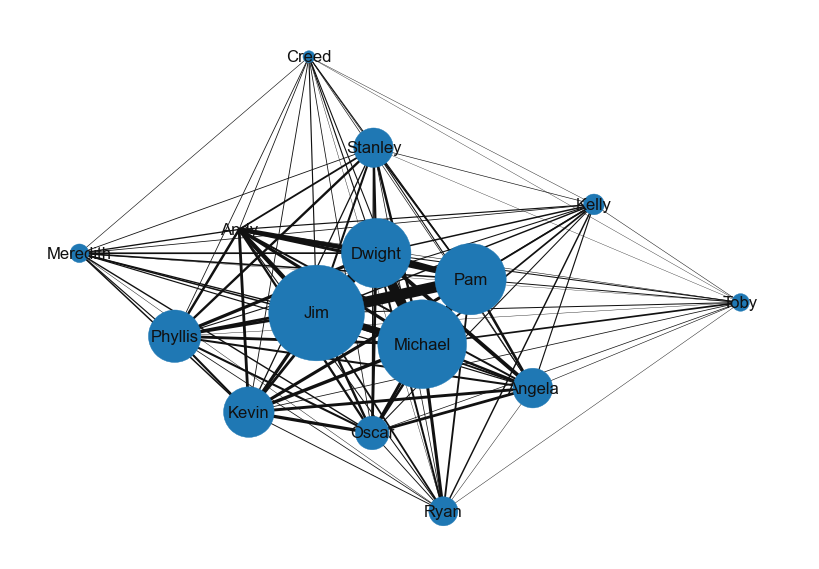

In [ ]:
import networkx as nx

graph = nx.Graph()
for character_tuple, count in character_edges.items():
    graph.add_edge(character_tuple[0], character_tuple[1], weight=count)
pos = nx.spring_layout(graph, k=100, iterations=500)
node_weights = [sum([d['weight'] for (u, v, d) in graph.edges(data=True) if u == node]) for node in graph.nodes()]
total_weights = sum(node_weights)
nx.draw(graph, pos, with_labels=True, node_size=[w/total_weights*20000 for w in node_weights], font_size=12,
            edgelist=[(u, v) for (u, v, d) in graph.edges(data=True)],
            width=[0.01*d['weight'] for (u, v, d) in graph.edges(data=True)])

In [ ]:
# TODO: plot this graph over time